# Dealing with inbalanced Dataset

We have a dataset in realisitc proportion, we could oversemple but it will not be good.

We have a lot of IBD events created by Andrea and also a lot of radioactivity events. If we sort them in temporal order we get that there will be a little amount of IBD in all the radioactivity events, because it is more frequently have radioactivity events respect of IBD that are rare. 

So in order to train our ML-algorithm we could use generated IBD events and generated Radioactivity events, so in that cse we have basically the same amount of data and the inbalanced problem will disappear. After the training, we test with inbalaced dataset.

Basically we use a smote 

We will se if it work...

In [1]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

## Imorting datasets
For the dataset we will use -unoscillated_IBD_userfile- and -radioactivity_userfile_7days- for the background.

In [2]:
file_BKG = up.open("../../../../mnt/fcufino/radioactivity_userfile_7days.root")
#file_IBD = up.open('../BrutalCuts/unoscillated_IBD_userfile.root') 
file_IBD = up.open('../../../../mnt/fcufino/ibd_userfile_1500days.root') 


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

dataset_IBD = {}
for key in ['recx', 'recy', 'recz', 'm_QEn', 'm_triggerT']:
    dataset_IBD[key] = dataset_IBD_all[key]

en_fact = 0.92
dataset_IBD["m_QEn"] = dataset_IBD["m_QEn"]*en_fact 

## Cheking temporal order


IBD:  0
BKG: 0
Cutted points:  86016    Total points:  172033


6583664

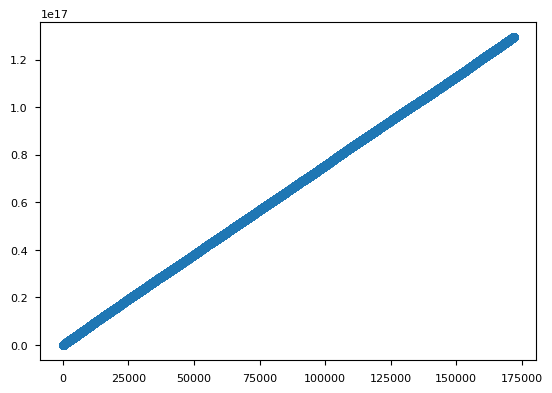

In [3]:
delta_t_IBD = dataset_IBD['m_triggerT'][1:] - dataset_IBD['m_triggerT'][:-1]
mask_IBD = np.logical_and(delta_t_IBD < 0, True)

print("IBD: ",mask_IBD.sum())

delta_t_BKG = dataset_BKG['m_triggerT'][1:] - dataset_BKG['m_triggerT'][:-1]
mask_BKG = np.logical_and(delta_t_BKG < 0, True)

print("BKG:", mask_BKG.sum())

#Plot of IBDs because they are not in temporal order
plt.scatter(np.arange(dataset_IBD['m_triggerT'].shape[0]),dataset_IBD['m_triggerT'])

mask_dt_IBD = np.logical_and(delta_t_IBD > 5*220e3, True)
print("Cutted points: ", mask_dt_IBD.sum(), " ", ' Total points: ', mask_dt_IBD.shape[0])

mask_dt_BKG = np.logical_and(delta_t_BKG < 5*220e3, True)
mask_dt_BKG.sum()


# Creation of two tables of features
One for IBD events and one for BKG, keeping them separately.


The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [4]:
from numba import njit, prange

In [5]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                delta_radius[i] = np.append(delta_radius[i], np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                E_pro[i] = np.append(E_pro[i], E[i])
                E_del[i] = np.append(E_del[i], E[j])
                R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t, expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t, expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

## For IBD events

In [6]:
features_IBD = {"delta_time": np.array([]), #Questa è vuota 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([])} 


features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"]  = create_features(
    dataset_IBD["recx"],
    dataset_IBD["recy"],
    dataset_IBD["recz"],
    dataset_IBD["m_QEn"],
    dataset_IBD["m_triggerT"])




/home/fcufino/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])

72147
72147
72147
72147
72147
72147


## For the BKG events

In [8]:
features_BKG = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([])}

cut = 800000

features_BKG["delta_time"],features_BKG["delta_radius"],features_BKG["E_pro"],features_BKG["E_del"],features_BKG["R_prompt"],features_BKG["R_delayed"] = create_features(
        dataset_BKG["recx"][:cut],
        dataset_BKG["recy"][:cut],
        dataset_BKG["recz"][:cut],
        dataset_BKG["m_QEn"][:cut],
        dataset_BKG["m_triggerT"][:cut])

In [9]:
print(features_BKG["delta_time"].shape[0])
print(features_BKG["delta_radius"].shape[0])
print(features_BKG["E_pro"].shape[0])
print(features_BKG["E_del"].shape[0])
print(features_BKG["R_prompt"].shape[0])
print(features_BKG["R_delayed"].shape[0])

90014
90014
90014
90014
90014
90014


## Plots before the cut

Delta time

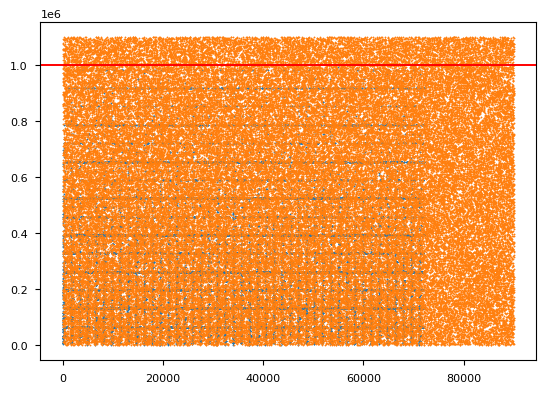

In [10]:
plt.scatter(np.arange(features_IBD["delta_time"].shape[0]), features_IBD["delta_time"], s=1)
plt.scatter(np.arange(features_BKG["delta_time"].shape[0]), features_BKG["delta_time"], s=1)
plt.axhline(1e6, c = 'red')

Delta radius

Ne perdiamo:  0


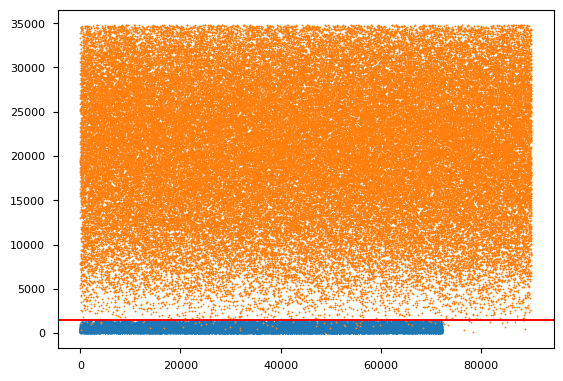

In [11]:
plt.scatter(np.arange(features_IBD["delta_radius"].shape[0]), features_IBD["delta_radius"], s=1)
plt.scatter(np.arange(features_BKG["delta_radius"].shape[0]), features_BKG["delta_radius"], s=1)

count = np.logical_and(True, features_IBD["delta_radius"]>1500)
print("Ne perdiamo: ", count.sum())
plt.axhline(1500, c = 'red')

## Cutting algorithm for BOTH IBD and BKG

In [12]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: #It is not necessery
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection

In [13]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [14]:
print(prompt_columns_IBD.sum(), prompt_columns_IBD.shape[0])
print(delay_columns_carb_IBD.sum(),delay_columns_carb_IBD.shape[0])
print(delay_columns_IBD.sum(),delay_columns_IBD.shape[0])



print("Accuracy: ", ((prompt_columns_IBD.sum() + delay_columns_carb_IBD.sum() + delay_columns_IBD.sum())  / (prompt_columns_IBD.shape[0] * 2)) * 100)

71573.0 72147
837.0 72147
70736.0 72147
Accuracy:  99.20440212344242


### BKG selection

In [15]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"],
                                                                           features_BKG["delta_radius"],
                                                                           features_BKG["E_pro"],
                                                                           features_BKG["E_del"])

In [72]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
print(delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])
print(delay_columns_BKG.sum(),delay_columns_BKG.shape[0])



print("Accuracy: ",  ((prompt_columns_BKG.sum() + delay_columns_carb_BKG.sum() + delay_columns_BKG.sum())  / (prompt_columns_BKG.shape[0] * 2)) * 100)

6.0 90014
0.0 90014
6.0 90014
Accuracy:  0.006665629790921413


### Plots after the cuts

(array([  0.,   0.,   3.,   0.,   3.,  28.,  95., 210., 270., 170.,  48.,
          9.,   1.]),
 array([4.4       , 4.48461538, 4.56923077, 4.65384615, 4.73846154,
        4.82307692, 4.90769231, 4.99230769, 5.07692308, 5.16153846,
        5.24615385, 5.33076923, 5.41538462, 5.5       ]),
 <BarContainer object of 13 artists>)

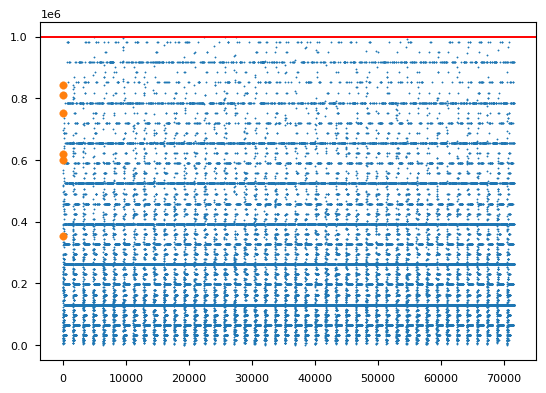

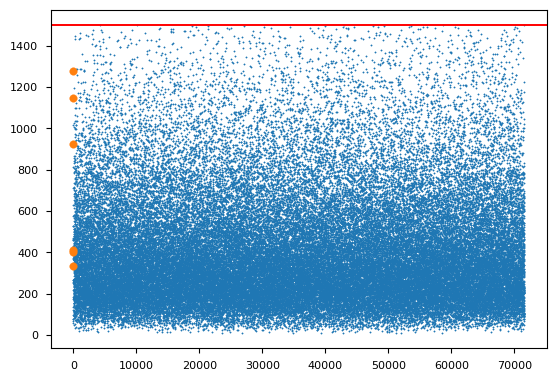

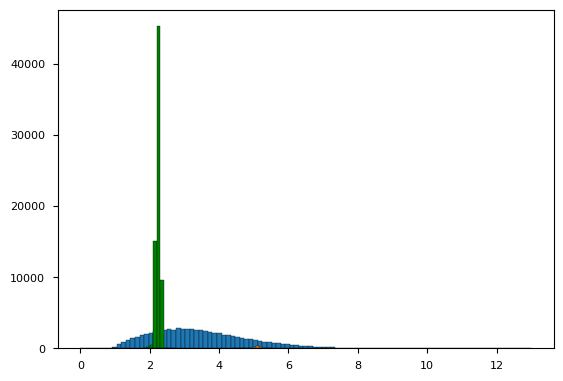

In [17]:
fig1 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_time"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_time"][prompt_columns_BKG == 1], s=30)
plt.axhline(1e6, c = 'red')

fig2 = plt.figure()
plt.scatter(np.arange(prompt_columns_IBD.sum()), features_IBD["delta_radius"][prompt_columns_IBD == 1], s=1)
plt.scatter(np.arange(prompt_columns_BKG.sum()), features_BKG["delta_radius"][prompt_columns_BKG == 1], s=30)
plt.axhline(1500, c = 'red')

fig3 = plt.figure()
plt.hist(features_IBD["E_pro"][prompt_columns_IBD == 1], np.linspace(0,13,100))
plt.hist(features_IBD["E_del"][delay_columns_IBD == 1], np.linspace(1.8,2.7,10), color= "green")
plt.hist(features_IBD["E_del"][delay_columns_carb_IBD == 1], np.linspace(4.4,5.5,14))

### Merging the IBD and BKG tables, but the tables before the cuts 

In [18]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    
    label = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Label': label}

In [19]:
all_feature = combine_dict(features_IBD,features_BKG)
print(all_feature)

{'E_pro': array([2.28723383, 5.28124189, 5.3664999 , ..., 1.89482427, 1.15486276,
       0.48397782]), 'R_delayed': array([16664.08203125, 16167.33496094, 15071.50683594, ...,
       14211.79980469, 17399.        ,  9817.43554688]), 'delta_radius': array([ 1015.95275879,    58.07221603,   369.15115356, ...,
       21861.48242188,  9185.72070312, 10784.61523438]), 'R_prompt': array([17318.61523438, 16185.61621094, 15036.12988281, ...,
       17399.        , 17399.        , 17399.        ]), 'delta_time': array([252534., 105088.,  45312., ...,  59000., 614324., 593075.]), 'E_del': array([2.19753385, 2.30674553, 2.24862695, ..., 0.19045562, 0.40454456,
       0.45348918]), 'Label': array([1., 1., 1., ..., 0., 0., 0.])}


### Shuffle in random order

In [20]:
# ottieni il numero di righe in ogni array
n_rows = all_feature['E_del'].shape[0]

# crea un nuovo ordine casuale degli indici delle righe
new_order = np.random.permutation(n_rows)

# estrai le righe nei nuovi indici
for key in all_feature:
    all_feature[key] = all_feature[key][new_order]


In [21]:

print(all_feature)
print(all_feature['Label'].sum())

{'E_pro': array([5.81259727, 0.62763035, 0.19730696, ..., 4.96037483, 3.63075137,
       0.20583045]), 'R_delayed': array([10003.67480469, 15908.80566406, 17399.        , ...,
       13567.61621094,  6892.72509766, 17399.        ]), 'delta_radius': array([  356.87939453, 18220.34179688, 12330.57226562, ...,
         320.70761108,   629.11102295, 17161.92382812]), 'R_prompt': array([ 9887.97363281, 17399.        , 12768.5234375 , ...,
       13620.69824219,  7370.18115234,  7407.68310547]), 'delta_time': array([393216., 132240., 797474., ..., 262144., 749568., 675063.]), 'E_del': array([2.25624418, 0.61891127, 1.18906152, ..., 2.25549126, 2.20087099,
       1.61119533]), 'Label': array([1., 0., 0., ..., 1., 1., 0.])}
72147.0


Now some statistics about the data

In [73]:
import pandas as pd
dataframe = pd.DataFrame({k:list(v) for k,v in all_feature.items()})
dataframe.head()

,E_pro,R_delayed,delta_radius,R_prompt,delta_time,E_del,Label
0,5.812597,10003.674805,356.879395,9887.973633,393216.0,2.256244,1.0
1,0.627630,15908.805664,18220.341797,17399.000000,132240.0,0.618911,0.0
2,0.197307,17399.000000,12330.572266,12768.523438,797474.0,1.189062,0.0
3,3.080531,17204.390625,193.697388,17141.679688,196608.0,2.061874,1.0
4,2.366869,7950.343262,98.458641,7900.369629,131072.0,2.221591,1.0


In [ ]:
# import seaborn as sns


# g = sns.PairGrid(dataframe, hue="Label", hue_kws={"marker": ["o", "s"]})


# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()



# Experimenting

## Cut Algorithm 

In [26]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_feature["delta_time"],
                                                              all_feature["delta_radius"],
                                                              all_feature["E_pro"],
                                                              all_feature["E_del"])

[ ] Chedere ad Andrea -> Mi aspettavo molto meno di 99%, magari perchè staimo considerando solamente un tipo di background? 

In [71]:
TP = np.logical_and(all_feature['Label'] == 1, prompt_columns == 1)
TN = np.logical_and(all_feature['Label'] == 0, prompt_columns == 0)
FN = np.logical_and(all_feature["Label"] == 1, prompt_columns == 0)
FP = np.logical_and(all_feature["Label"] == 0, prompt_columns == 1) 

print(((TP.sum()+TN.sum())/(TP.sum()+TN.sum()+FN.sum()+FN.sum())) * 100)
print(all_feature["Label"].sum())
print(prompt_columns.sum())

99.29453262786596
72147.0
71579.0


## XGBClassifier

In [28]:
all_feature.keys()

dict_keys(['E_pro', 'R_delayed', 'delta_radius', 'R_prompt', 'delta_time', 'E_del', 'Label'])

In [29]:
from sklearn.model_selection import train_test_split

X = np.concatenate((all_feature['delta_time'], all_feature['E_del'], all_feature['E_pro'], all_feature['R_delayed'], all_feature['R_prompt'], all_feature['delta_radius']), axis=0).reshape(-1,6)
Y = all_feature['Label'].reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)



In [30]:
from sklearn.metrics import roc_auc_score
import time
import xgboost as xgb


#Using default parameters and train
model = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=100, max_depth=3, learning_rate = 0.1)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)


# make predictions for test data
y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)


[0]	validation_0-error:0.44456	validation_0-logloss:0.69196	validation_1-error:0.44473	validation_1-logloss:0.69198


/home/fcufino/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-error:0.44433	validation_0-logloss:0.69099	validation_1-error:0.44495	validation_1-logloss:0.69106
[2]	validation_0-error:0.44429	validation_0-logloss:0.69021	validation_1-error:0.44486	validation_1-logloss:0.69029
[3]	validation_0-error:0.44421	validation_0-logloss:0.68956	validation_1-error:0.44501	validation_1-logloss:0.68969
[4]	validation_0-error:0.44420	validation_0-logloss:0.68904	validation_1-error:0.44495	validation_1-logloss:0.68919
[5]	validation_0-error:0.44419	validation_0-logloss:0.68862	validation_1-error:0.44489	validation_1-logloss:0.68879
[6]	validation_0-error:0.44436	validation_0-logloss:0.68826	validation_1-error:0.44473	validation_1-logloss:0.68849
[7]	validation_0-error:0.44433	validation_0-logloss:0.68796	validation_1-error:0.44498	validation_1-logloss:0.68824
[8]	validation_0-error:0.44432	validation_0-logloss:0.68772	validation_1-error:0.44498	validation_1-logloss:0.68803
[9]	validation_0-error:0.44430	validation_0-logloss:0.68752	validation_1

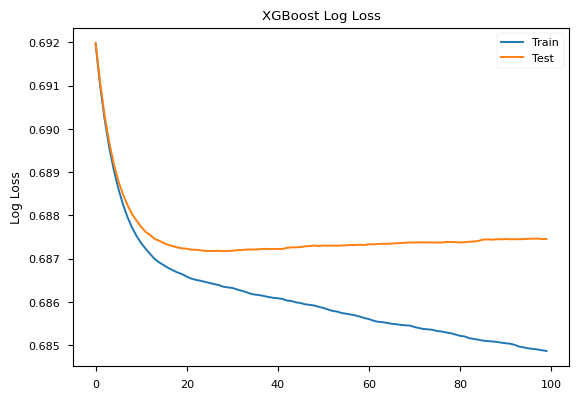

In [31]:
# plot log loss

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')

ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

plt.ylabel('Log Loss')

plt.title('XGBoost Log Loss')

plt.show()


Qui si utilizza il metodo SHAP in combinazione con  XGBoost. Nello specifico, SHAP utilizza il metodo Tree SHAP per spiegare le predizioni dell'algoritmo XGBoost, ovvero valuta il contributo di ogni variabile in ogni nodo dell'albero di decisione utilizzato da XGBoost per la predizione.

In [32]:
# import shap
# features_names = [dataset_IBD.keys()]
# # Creo un oggetto explainer SHAP
# explainer = shap.Explainer(XGBClassifier, X_train)

# # Calcolo i valori di Shapley per il set di test
# shap_values = explainer(X_test)

# # Plotto il summary plot di SHAP
# shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [33]:
# # Importnce plot
# shap.summary_plot(shap_values, X_test, feature_names=feature_names , plot_type="bar")


Text(0, 0.5, 'Background Rejection')

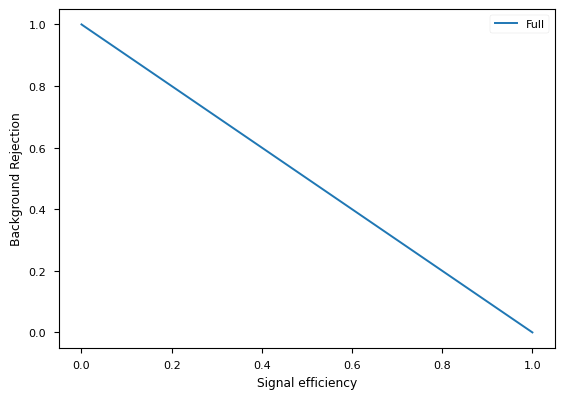

In [34]:
from sklearn.metrics import roc_curve 

fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(1)
plt.plot(tpr, 1-fpr, label='Full')

plt.legend(loc=1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background Rejection')

Optimizing XGBoost

In [35]:
from sklearn.model_selection import GridSearchCV 

#Create values to search over
cv_params = {'max_depth': [3,4,6], #Maximum depth of a tree, increasing increase complxity
              'min_child_weight': [1,3,5],
                'learning_rate':[0.001, 0.01, 0.1, 0.3]} #Step size uset to prevent overfitting 


ind_params = {'n_estimators': 300, 'seed':1, 'colsample_bytree': 1, 
             'objective': 'binary:logistic'}

opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                            scoring = 'accuracy',
                            cv = 5,
                            n_jobs = -1,
                            verbose=3)

opt_XGBclassifier.fit(X_train, y_train)
opt_XGBclassifier.cv_results_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 3/5] END learning_rate=0.001, max_depth=3, min_child_weight=1;, score=0.555 total time=  18.8s
[CV 4/5] END learning_rate=0.001, max_depth=3, min_child_weight=3;, score=0.555 total time=  18.8s
[CV 4/5] END learning_rate=0.001, max_depth=3, min_child_weight=5;, score=0.555 total time=  19.1s
[CV 2/5] END learning_rate=0.001, max_depth=3, min_child_weight=3;, score=0.555 total time=  19.3s
[CV 5/5] END learning_rate=0.001, max_depth=3, min_child_weight=3;, score=0.555 total time=  19.4s
[CV 3/5] END learning_rate=0.001, max_depth=3, min_child_weight=5;, score=0.555 total time=  19.6s
[CV 5/5] END learning_rate=0.001, max_depth=3, min_child_weight=5;, score=0.555 total time=  19.5s
[CV 1/5] END learning_rate=0.001, max_depth=3, min_child_weight=5;, score=0.555 total time=  19.6s
[CV 1/5] END learning_rate=0.001, max_depth=3, min_child_weight=1;, score=0.555 total time=  19.6s
[CV 2/5] END learning_rate=0.001, max_depth=3, 

{'mean_fit_time': array([19.73254991, 19.29180393, 19.43537745, 25.70858579, 25.52529001,
        25.51654596, 37.6903132 , 37.26398306, 37.80366449, 18.84854975,
        18.8663322 , 18.87492228, 24.98642488, 25.28378086, 25.36851816,
        37.51843581, 37.34384074, 37.21019301, 19.76950822, 19.83206835,
        19.57019758, 25.65093617, 26.26297684, 25.54059725, 39.43442078,
        39.31901269, 39.51156139, 19.92581615, 20.01264076, 19.69972062,
        26.78027945, 26.48664093, 26.32969971, 40.05889568, 39.75384893,
        39.35058641]),
 'std_fit_time': array([0.60427432, 0.32394242, 0.2222642 , 0.71630512, 0.51765508,
        1.08781966, 0.30983626, 0.71362568, 0.37687957, 0.22865394,
        0.14328668, 0.46343407, 0.42579314, 0.58286614, 0.40298495,
        0.84053282, 0.8151934 , 0.45389862, 0.34435985, 0.55226321,
        0.52255281, 0.43802309, 0.37146086, 0.45519687, 0.65665081,
        0.54754803, 0.50413381, 0.38783909, 0.48295281, 0.2555095 ,
        0.3405663 , 0.641

In [36]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBclassifier.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBclassifier.best_params_)

#Fit performance on the test set
XGBclassifier_final=opt_XGBclassifier.best_estimator_
y_pred_final=XGBclassifier_final.predict(X_test)
print("Model Accuray with optimal parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))

The optimal score on training set is 0.555
The optimal parameters for the classifier are:
{'learning_rate': 0.001, 'max_depth': 4, 'min_child_weight': 3}
Model Accuray with optimal parameters: 55.52%
The  AUC score is 0.50


## PyTorch Neural Network

In [37]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        #Here i added a layer because i wanted to try to increase the accuracy thinking that few features are a problem          
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.layer4(out)
        return out

# Example usage
input_size = 6
hidden_size = 200
num_classes = 2
net = Net(input_size, hidden_size, num_classes).cuda()


import torch.nn.functional as F
import torch.optim as optim

#Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#Train the network
for epoch in range(10):
     
    running_loss = 0.0
    for i in range(0, len(X_train), 4):
        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.Tensor(X_train[i:i+4]).cuda()
        print()
        labels = torch.LongTensor(y_train[i:i+4]).cuda() #Creando mini-batches di 4 elementi, il tensore delle labels ha dimensione 4x1
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

#Test the network
correct = 0
total = 0
with torch.no_grad():
    for i in range(0, len(X_test), 4):
        inputs = torch.Tensor(X_test[i:i+4]).cuda()
        labels = torch.LongTensor(y_test[i:i+4]).cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.reshape(-1)).sum().item()

print('Accuracy of the network on the 10000: %d %%' % (100 * correct / total))

# #Save the model
# PATH = './xgboost_net.pth'
# torch.save(net.state_dict(), PATH)

# #Load the model
# net = Net(input_size, hidden_size, num_classes)
# net.load_state_dict(torch.load(PATH))




KeyboardInterrupt: 

## SVM kernel rbf
I thought that maybe I only get 55% accurcay because there few features and the algorithm is not able to find the best hyperplane in the feature space. So I tried to use a kernel rbf in order to map the features in a higher dimension space, where maybe the algorithm is able to find a better hyperplane.

In [ ]:
from sklearn import svm
# Definisci il modello SVM
svm_rbf = svm.SVC(kernel='rbf', C=1, gamma='scale')

y_train = y_train.ravel()
# Addestra il modello sui dati di addestramento
svm_rbf.fit(X_train, y_train)

SVC(C=1)

In [ ]:
accuracy = svm_rbf.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.5557611075139518


# TODO list

[ v ] Create two distinct features' tables (one for 100.000 unoscillated IBDs, one for the 7days radioactivity dataset). Remember to add R_ptompt and R_delayed to the stored features


[ v ] Run your standard selection on the two tables separately to estimate efficiency and purity.


[ v ] Remember to remove the "label == 1" from your function.


[ v ] Concatenate the two tables, shuffle the order of the rows and start experimenting. Check the performances of XGBoost compared to the standard selection.

For any problem, write us and we can discuss about it! Have a nice weekend